In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit

In [2]:
N = 10  # number of nodes in graph

# COOrdinate graph representation
row = tf.constant(np.array([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 8, 8, 8, 9, 9], dtype=np.int32))
col = tf.constant(np.array([1, 2, 3, 0, 6, 0, 5, 0, 4, 5, 3, 5, 2, 3, 4, 6, 9, 1, 5, 7, 8, 6, 8, 6, 7, 9, 7, 8], dtype=np.int32))
hashes = 10 * row + col

In [3]:
tau = 1.0 / tf.cast(tf.gather(tf.math.segment_sum(tf.ones_like(row), row), row), tf.float32)
eta = tf.ones_like(row, dtype=tf.float32)

proba = tau * eta
proba = proba / tf.gather(tf.math.segment_sum(proba, row), row)

threshold = tf.math.cumsum(proba) - tf.cast(row, dtype=tf.float32)

display(proba)

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.33333334, 0.33333334, 0.33333334, 0.5       , 0.5       ,
       0.5       , 0.5       , 0.33333334, 0.33333334, 0.33333334,
       0.5       , 0.5       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.25      , 0.25      , 0.25      ,
       0.25      , 0.5       , 0.5       , 0.33333334, 0.33333334,
       0.33333334, 0.5       , 0.5       ], dtype=float32)>

In [4]:
# Both do the same, but apparrently segment sum is not XLA-compilable
tf.math.segment_sum(proba, row)
tf.math.reduce_sum(tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [11]:
# Probability normalization (XLA friendly)
proba / tf.gather(
    tf.math.reduce_sum(tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
    row)

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.33333334, 0.33333334, 0.33333334, 0.5       , 0.5       ,
       0.5       , 0.5       , 0.33333334, 0.33333334, 0.33333334,
       0.5       , 0.5       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.25      , 0.25      , 0.25      ,
       0.25      , 0.5       , 0.5       , 0.33333334, 0.33333334,
       0.33333334, 0.5       , 0.5       ], dtype=float32)>

In [4]:
@tf.function
def traverse_one_step(row, col, ants, threshold):
    thresholds_per_agent = tf.gather(
        tf.where(row == tf.reshape(tf.range(10, dtype=tf.int32), [-1, 1]), threshold, 0),
        indices=ants)

    targets = tf.gather(
        col,
        tf.argmax((thresholds_per_agent - tf.random.uniform([9])[:, tf.newaxis]) > 0, axis=-1))

    return targets

In [5]:
@tf.function
def proceed_one_epoch(row, col, hashes, ants, history, proba, starts, end, sink, source, h_len):
    threshold = tf.math.cumsum(proba) - tf.cast(row, dtype=tf.float32)
    ants = traverse_one_step(row, col, ants, threshold)
    history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], end), tf.range(9)])), ants)

    is_at_target = tf.boolean_mask(tf.range(9), ants == sink)
    t = tf.tile(tf.gather(history, is_at_target, axis=-1), [2, 1])[:h_len + end + 1]
    s = tf.gather(tf.where(starts > end, starts, starts + h_len), is_at_target)

    history = tf.tensor_scatter_nd_update(
        history, tf.transpose(tf.stack([tf.fill([9], end), tf.range(9)])), tf.where(ants == sink, source, ants))

    starts = tf.where(ants == sink, end, starts)
    starts = tf.where(ants == source, end, starts)
    ants = tf.where(ants == sink, source, ants)

    edges_to_enhance = tf.boolean_mask(
        tf.reshape(tf.transpose(tf.stack([t[:-1, :], t[1:, :]], axis=-1), [1, 0, 2]), [-1, 2]),
        tf.reshape(tf.transpose((tf.cumsum(tf.ones_like(t), axis=0) - 1)[1:, :] > s), [-1])
    )

    hashed_selected_edges = 10 * edges_to_enhance[:, 0] + edges_to_enhance[:, 1]
    updates = tf.reduce_sum(tf.cast(tf.reshape(hashed_selected_edges, [-1, 1]) == hashes, dtype=tf.int32), axis=0)

    proba *= tf.pow(1.05, tf.cast(updates, dtype=tf.float32))
    proba = tf.maximum(proba, 0.125 * eta)
    proba = proba / tf.gather(
        tf.math.reduce_sum(
            tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
        row)
    
    return proba, ants, history, starts, tf.reduce_sum(tf.ones_like(s))

### No GPU optimization (CPU run)

In [15]:
start_time = timeit.default_timer()

ants = tf.zeros([9], dtype=tf.int32)
starts = tf.zeros_like(ants, dtype=tf.int32)
h_len = 20
source = 0
sink = 9
history = tf.zeros([h_len, 9], dtype=tf.int32)
history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

tau = 1.0 / tf.cast(tf.gather(tf.math.segment_sum(tf.ones_like(row), row), row), tf.float32)
eta = tf.ones_like(row, dtype=tf.float32)

proba = tau * eta
proba = proba / tf.gather(tf.math.segment_sum(proba, row), row)

stats = []

for step in range(1, 2000):
    end = step % h_len
    threshold = tf.math.cumsum(proba) - tf.cast(row, dtype=tf.float32)
    ants = traverse_one_step(row, col, ants, threshold)
    history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], end), tf.range(9)])), ants)

    is_at_target = tf.boolean_mask(tf.range(9), ants == sink)
    t = tf.tile(tf.gather(history, is_at_target, axis=-1), [2, 1])[:h_len + end + 1]
    s = tf.gather(tf.where(starts > end, starts, starts + h_len), is_at_target)

    stats += [s.shape[0]]

    history = tf.tensor_scatter_nd_update(
        history, tf.transpose(tf.stack([tf.fill(9, end), tf.range([9])])), tf.where(ants == sink, source, ants))

    starts = tf.where(ants == sink, end, starts)
    starts = tf.where(ants == source, end, starts)
    ants = tf.where(ants == sink, source, ants)

    edges_to_enhance = tf.boolean_mask(
        tf.reshape(tf.transpose(tf.stack([t[:-1, :], t[1:, :]], axis=-1), [1, 0, 2]), [-1, 2]),
        tf.reshape(tf.transpose((tf.cumsum(tf.ones_like(t), axis=0) - 1)[1:, :] > s), [-1])
    )

    hashed_selected_edges = 10 * edges_to_enhance[:, 0] + edges_to_enhance[:, 1]
    updates = tf.reduce_sum(tf.cast(tf.reshape(hashed_selected_edges, [-1, 1]) == hashes, dtype=tf.int32), axis=0)

    proba *= tf.pow(1.1, tf.cast(updates, dtype=tf.float32))
    proba = tf.maximum(proba, 0.05 * eta)
    proba = proba / tf.gather(tf.math.segment_sum(proba, row), row)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 20.4354s


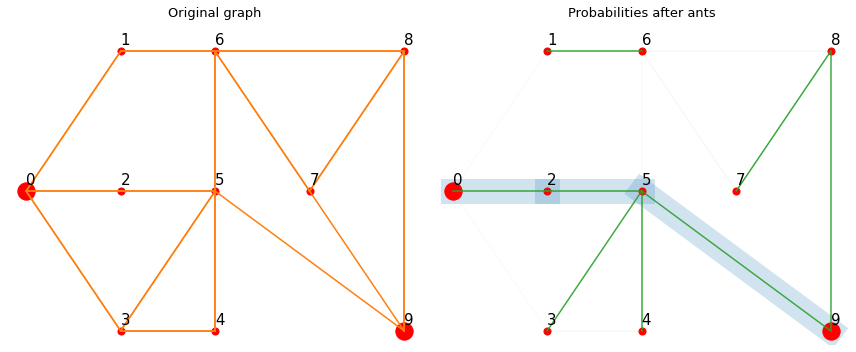

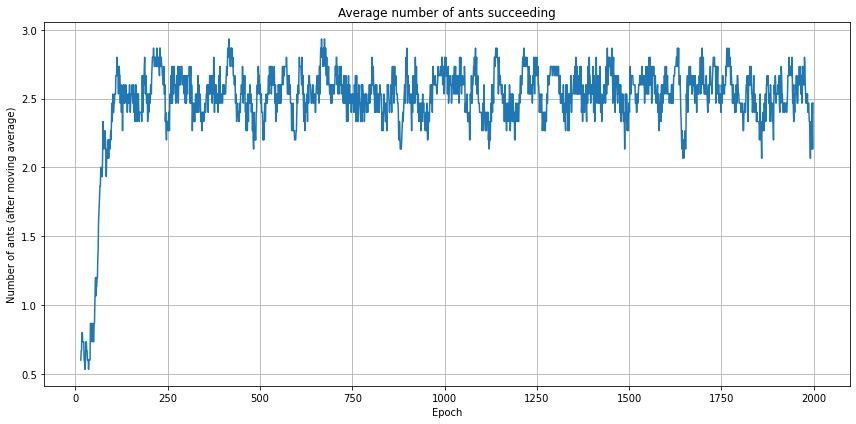

In [16]:
points = [
    [0, 0], [1, 1], [1, 0], [1, -1], [2, -1], [2, 0], [2, 1], [3, 0], [4, 1], [4, -1]
]

best_path = [source]
for i in range(N):
    best_path += [int(col[tf.argmax(tf.where(row == best_path[-1], proba, 0))])]
    if best_path[-1] == sink:
        break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original graph\n", fontsize=13)
for i, point in enumerate(points):
    s = 300 if i in [0, len(points) - 1] else 50
    plt.scatter(point[0], point[1], c='r', s=s)
    plt.text(point[0], point[1] + 0.05, str(i), fontsize=15)

for i, j in zip(list(row.numpy()), list(col.numpy())):
    plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], c='tab:orange')

plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Probabilities after ants\n", fontsize=13)
for i, point in enumerate(points):
    s = 300 if i in [0, len(points) - 1] else 50
    plt.scatter(point[0], point[1], c='r', s=s)
    plt.text(point[0], point[1] + 0.05, str(i), fontsize=15)

for i, j, p in tf.stack([tf.cast(row, tf.float32), tf.cast(col, tf.float32), proba]).numpy().T:
    i, j = int(i), int(j)
    if i < j:
        plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], c='tab:green', alpha=p)

for i, j in zip(best_path[:-1], best_path[1:]):
    plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], c='tab:blue', lw=25, zorder=-2, alpha=0.2)


plt.axis('off')

plt.tight_layout()
plt.show()

print()
plt.figure(figsize=(12, 6))

ma = 15
cumusum = np.cumsum(stats)
avg_number_of_successful_ants = (cumusum[ma:] - cumusum[:-ma]) / ma
plt.title("Average number of ants succeeding")
plt.xlabel("Epoch")
plt.ylabel("Number of ants (after moving average)")
plt.plot(np.arange(ma, len(stats)), avg_number_of_successful_ants)
plt.grid()
plt.tight_layout()
plt.show()

### Some GPU optimization, proceed epoch as tf.function (CPU run)

In [17]:
start_time = timeit.default_timer()

ants = tf.zeros([9], dtype=tf.int32)
starts = tf.zeros_like(ants, dtype=tf.int32)
h_len = 20
source = 0
sink = 9
history = tf.zeros([h_len, 9], dtype=tf.int32)
history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill(9, 0), tf.range(9)])), ants)

tau = 1.0 / tf.cast(tf.gather(tf.math.segment_sum(tf.ones_like(row), row), row), tf.float32)
eta = tf.ones_like(row, dtype=tf.float32)

proba = tau * eta
proba = proba / tf.gather(tf.math.segment_sum(proba, row), row)

stats = []

for step in range(1, 2000):
    end = step % h_len
    proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, tf.constant(end), sink, source, h_len)
    stats += [s]

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 3.5072s


### Some GPU optimization, proceed epoch as tf.function (GPU run)

In [7]:
# GPU Run
start_time = timeit.default_timer()

ants = tf.zeros([9], dtype=tf.int32)
starts = tf.zeros_like(ants, dtype=tf.int32)
h_len = 20
source = 0
sink = 9
history = tf.zeros([h_len, 9], dtype=tf.int32)
history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill(9, 0), tf.range(9)])), ants)

tau = 1.0 / tf.cast(tf.gather(tf.math.segment_sum(tf.ones_like(row), row), row), tf.float32)
eta = tf.ones_like(row, dtype=tf.float32)

proba = tau * eta
proba = proba / tf.gather(tf.math.segment_sum(proba, row), row)

stats = []

for step in range(1, 2000):
    end = step % h_len
    proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, tf.constant(end), sink, source, h_len)
    stats += [s]

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 4.8191s


### Everything inside tf.function (CPU run)

In [28]:
@tf.function(reduce_retracing=False, jit_compile=False)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [31]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.4914s


In [59]:
@tf.function(reduce_retracing=False, jit_compile=True)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [74]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.1919s


In [40]:
@tf.function(reduce_retracing=True, jit_compile=False)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [52]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.5744s


In [75]:
@tf.function(reduce_retracing=True, jit_compile=True)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [79]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.1806s


In [19]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    gpu_run(row, col, hashes, tau, epochs=150000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 11.3856s


### Everything inside tf.function (GPU run)

In [8]:
@tf.function(reduce_retracing=True, jit_compile=True)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [18]:
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.3614s


In [13]:
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    gpu_run(row, col, hashes, tau, epochs=150000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 18.3746s


### Everything inside tf.function (high-end GPU run)

In [7]:
@tf.function(reduce_retracing=True, jit_compile=True)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [14]:
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.2948s


In [15]:
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    gpu_run(row, col, hashes, tau, epochs=150000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 22.2890s


### Everything inside tf.function (TPU run)

In [6]:
@tf.function(reduce_retracing=True, jit_compile=True)
def gpu_run(row, col, hashes, tau, epochs):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([9], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            h_len = 20
            source = 0
            sink = 9
            history = tf.zeros([h_len, 9], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([9], 0), tf.range(9)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(10), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len)
                step += 1
            
            return proba

In [32]:
start_time = timeit.default_timer()

with tf.device('tpu:0'):
    gpu_run(row, col, hashes, tau, epochs=2000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.1773s


In [34]:
start_time = timeit.default_timer()

with tf.device('tpu:0'):
    gpu_run(row, col, hashes, tau, epochs=150000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 13.9803s
